In [1]:
%ls

BMEG3103_hw/           BMEG3103_project1_VGG16.ipynb*
BMEG3103_hw1-1.ipynb*  BMEG3103_tutorial7/
BMEG3103_hw1.ipynb*    BMEG3103_tutorial7_correlation.ipynb*
BMEG3103_project/


In [2]:
# !pip install matplotlib scikit-learn

In [3]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='tensorflow')

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)

import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)

!export TF_CPP_MIN_LOG_LEVEL=2

In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score

2024-11-18 17:58:26.902311: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731923906.995221   18999 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731923907.022449   18999 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
# Define paths to your datasets
train_dir = 'BMEG3103_project/project1_dataset/train'
val_dir = 'BMEG3103_project/project1_dataset/val'
test_dir = 'BMEG3103_project/project1_dataset/test'

In [6]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    brightness_range=[0.5, 1.5],
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [7]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

Found 4192 images belonging to 2 classes.
Found 1040 images belonging to 2 classes.
Found 698 images belonging to 2 classes.


In [8]:
# Load the pre-trained VGG16 model
base_model = tf.keras.applications.VGG16(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

# Unfreeze the base model for fine-tuning
base_model.trainable = True

for layer in base_model.layers[:15]:
    layer.trainable = False
for layer in base_model.layers[15:]:
    layer.trainable = True

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=l2(0.01)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(2, activation='softmax')
])

# Compile the model with a lower learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])


I0000 00:00:1731923910.379372   18999 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13553 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 Ti SUPER, pci bus id: 0000:01:00.0, compute capability: 8.9


In [9]:
# Add early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Define a learning rate scheduler
def scheduler(epoch, lr):
    if epoch < 10:
        return float(lr)
    else:
        return float(lr * tf.math.exp(-0.1))

def cosine_annealing(epoch, lr, total_epochs):
    return 0.5 * lr * (1 + np.cos(np.pi * epoch / total_epochs))

# Define the total number of epochs
total_epochs = 100

# Create the learning rate scheduler callback
lr_scheduler = LearningRateScheduler(lambda epoch, lr: cosine_annealing(epoch, lr, total_epochs))

# Train the model with learning rate scheduler
history = model.fit(
    train_generator,
    epochs=total_epochs,
    validation_data=val_generator,
    callbacks=[early_stopping, lr_scheduler]
)

/home/user/miniconda3/envs/tensorflow/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100


I0000 00:00:1731923913.253732   19228 service.cc:148] XLA service 0x7f2554007240 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731923913.258425   19228 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Ti SUPER, Compute Capability 8.9
I0000 00:00:1731923913.484778   19228 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/131 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.4219 - loss: 4.9816 

I0000 00:00:1731923918.183762   19228 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


131/131 ━━━━━━━━━━━━━━━━━━━━ 52s 349ms/step - accuracy: 0.5644 - loss: 4.4855 - val_accuracy: 0.8827 - val_loss: 3.9618 - learning_rate: 1.0000e-05
Epoch 2/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 48s 367ms/step - accuracy: 0.7096 - loss: 4.1467 - val_accuracy: 0.9231 - val_loss: 3.7385 - learning_rate: 9.9975e-06
Epoch 3/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 78s 332ms/step - accuracy: 0.7139 - loss: 4.0058 - val_accuracy: 0.8721 - val_loss: 3.6702 - learning_rate: 9.9877e-06
Epoch 4/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 43s 332ms/step - accuracy: 0.7577 - loss: 3.8962 - val_accuracy: 0.8635 - val_loss: 3.6062 - learning_rate: 9.9655e-06
Epoch 5/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 43s 329ms/step - accuracy: 0.7839 - loss: 3.8063 - val_accuracy: 0.8394 - val_loss: 3.6116 - learning_rate: 9.9262e-06
Epoch 6/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 43s 328ms/step - accuracy: 0.7960 - loss: 3.7087 - val_accuracy: 0.8038 - val_loss: 3.6594 - learning_rate: 9.8651e-06
Epoch 7/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 43s 325ms/s

In [10]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Accuracy: {test_accuracy:.4f}')

# Get predictions and true labels
test_generator.reset()
preds = model.predict(test_generator)
preds = np.argmax(preds, axis=1)
true_labels = test_generator.classes

22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 262ms/step - accuracy: 0.9049 - loss: 2.7456
Test Accuracy: 0.9083
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step


In [11]:
# Calculate precision, recall, and confusion matrix
threshold = 0.5  # You can change this value to balance precision and recall
preds = (model.predict(test_generator)[:, 1] > threshold).astype(int)

test_precision = precision_score(true_labels, preds)
test_recall = recall_score(true_labels, preds)
f1 = f1_score(true_labels, preds)
conf_matrix = confusion_matrix(true_labels, preds)

print(f'F1 Score: {f1:.4f}')
print(f'Test Precision: {test_precision:.4f}')
print(f'Test Recall: {test_recall:.4f}')
print('Confusion Matrix:')
print(conf_matrix)

22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step
F1 Score: 0.9263
Test Precision: 0.9220
Test Recall: 0.9306
Confusion Matrix:
[[232  34]
 [ 30 402]]


In [12]:
# # Experiment with different thresholds
# pred_probs = model.predict(test_generator)[:, 1]
# thresholds = [0.3, 0.4, 0.5, 0.6, 0.7]
# for threshold in thresholds:
#     preds = (pred_probs > threshold).astype(int)
#     test_precision = precision_score(true_labels, preds)
#     test_recall = recall_score(true_labels, preds)
#     print(f'Threshold: {threshold}')
#     print(f'Precision: {test_precision:.4f}')
#     print(f'Recall: {test_recall:.4f}')
#     print('---')

In [13]:
# # Calculate confusion matrix for the chosen threshold (e.g., 0.5)
# chosen_threshold = 0.5
# preds = (pred_probs > chosen_threshold).astype(int)
# conf_matrix = confusion_matrix(true_labels, preds)

# print('Confusion Matrix:')
# print(conf_matrix)

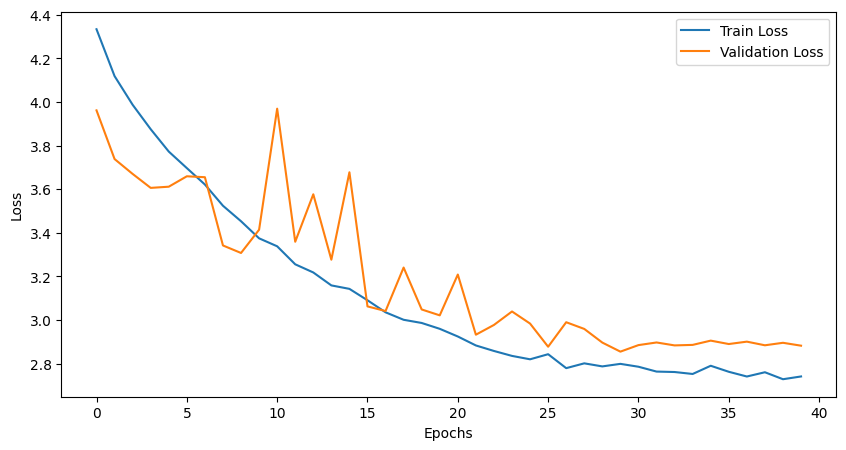

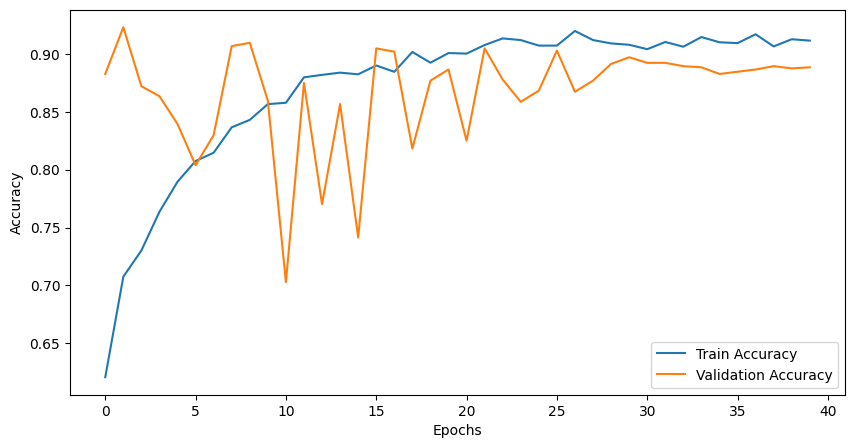

In [14]:
# Plot training and validation loss over epochs
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot validation accuracy over epochs
plt.figure(figsize=(10,5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()